# Zillow Neighborhood Shapes

Import python scientific suite

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
import seaborn as sns
import scipy
import pylab

# This is importing a "future" python version 3 print function.
from __future__ import print_function
from __future__ import division
%matplotlib inline
sns.set()
sns.set_context('paper', font_scale = 1.5)
sns.set_style('ticks')

/Users/Franklin/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Here, we set the directory where the neighborhood shape files are located

In [2]:
hood_dir = '/Volumes/1TB_BAY/zillow_sets/neighborhood_shapes/' #on my computer, the location of the neighborhood shape files
file_dir = '/Volumes/1TB_BAY/yelp_dataset_challenge_academic_dataset/'
fig_path = './paper/'

We will import the 'shapefile' package, which allows us to read in the neighborhood shape information, and also the 'Basemap' package, which allows us to superimpose background map imagery.

If you have conda, you can get the Basemap package by typing 

#conda install -c anaconda basemap=1.0.7

at the terminal

In [3]:
import shapefile
from mpl_toolkits.basemap import Basemap

In [4]:
myshp = open('merged.shp')
mydbf = open('merged.dbf')
sf = shapefile.Reader(shp = myshp, dbf = mydbf) #load all neighborhoods

In [5]:
len(sf.records()) #how many neighborhoods are there?

6958

In [6]:
nc = pd.read_csv('shape_centers.txt', header = None).rename(columns = {0: 'ID'})
re = pd.DataFrame(sf.records()).rename(columns = {4: 'ID'}) #records

loc_records = pd.merge(nc, re, on = 'ID')
loc_records.rename(columns = {'1_x': 'lon', '2_x': 'lat', 0: 'state','1_y': 'county', '2_y': 'city', 3:'neighborhood'}, inplace = True)
loc_records[['ID', 'state', 'county', 'city', 'neighborhood', 'lon', 'lat']].to_csv('neighborhood_locations.csv')

Here, we are drwaing the Zillow Neighborhoods around the phoenix area, just to see what they look like!

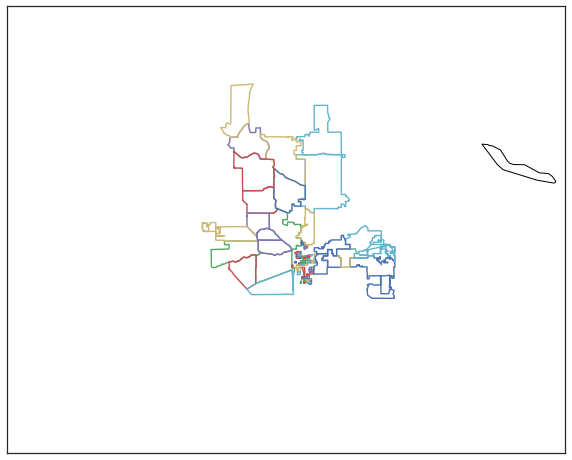

In [7]:
pylab.rcParams['figure.figsize'] = (10,8)

m = Basemap(width=200000,height=160000,projection='lcc',
            resolution='h',lat_1=34.0,lat_2=34.5,lat_0=33.5, lon_0=-112.0)
m.drawcoastlines()

for shape in sf.shapes():
    x,y = m(np.array(shape.points).T[0], np.array(shape.points).T[1])
    m.plot(x,y)

In [ ]:
plt.scatter(b['longitude'], b['latitude'], lw = 0, s = 1, c = b['attributes.Price Range'], cmap = 'jet')
plt.colorbar()
plt.xlim(-112.5,-111.5)
plt.ylim(33,34)

In [ ]:
b[['name','business_id','longitude','latitude','stars','review_count','attributes.Price Range','categories']]

Let's read in the yelp dataset

In [24]:
b = pd.read_csv(file_dir + 'yelp_academic_dataset_business.csv') #b for business

/Users/Franklin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (1,4,7,17,29,49,60,62,79,86,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Now, Let's draw the neighborhood borders for Phoenix, AZ, and plot all of the yelp businesses

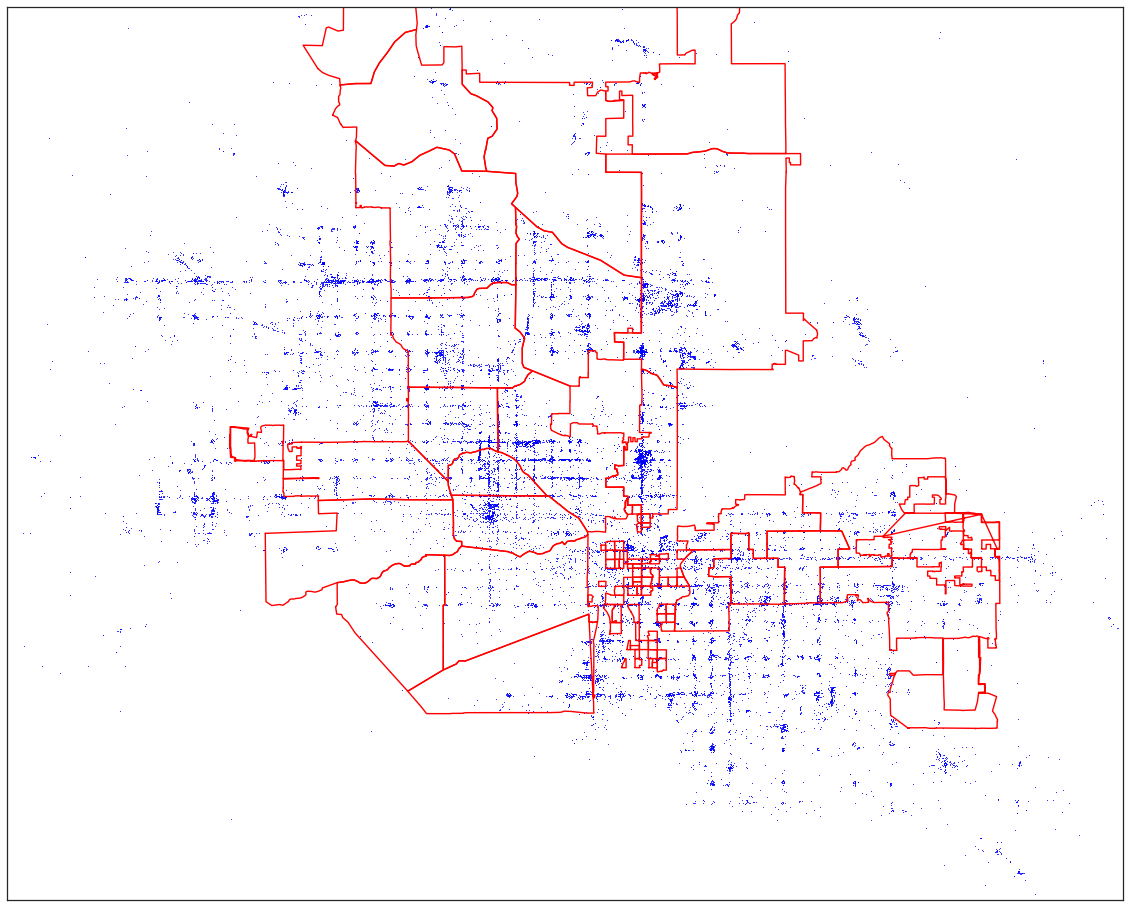

In [10]:
pylab.rcParams['figure.figsize'] = (20,16)

m = Basemap(width=100000,height=80000,projection='lcc',
            resolution='h',lat_1=34.0,lat_2=34.5,lat_0=33.5, lon_0=-112.0)
m.drawcoastlines()

for shape in sf.shapes():
    x,y = m(np.array(shape.points).T[0], np.array(shape.points).T[1])
    bx, by = m(np.array(b['longitude']), np.array(b['latitude']))
    m.plot(x,y, color = 'red')
    
m.scatter(bx,by, s = 1, lw = 0)
plt.savefig(fig_path + 'phx_test.png', dpi = 300, fmt = 'png')

We need a way to check (for each business) which polygon the business is in.
The following code was stolen from: http://geospatialpython.com/2011/01/point-in-polygon.html

In [13]:
def point_in_poly(x,y,poly):

    n = len(poly)
    inside = False

    p1x,p1y = poly[0]
    for i in range(n+1):
        p2x,p2y = poly[i % n]
        if y > min(p1y,p2y):
            if y <= max(p1y,p2y):
                if x <= max(p1x,p2x):
                    if p1y != p2y:
                        xints = (y-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
                    if p1x == p2x or x <= xints:
                        inside = not inside
        p1x,p1y = p2x,p2y

    return inside

This is an attempt to find the zillow neighborhood corresponding to each yelp business. This loop works, however it is much too slow (would take over a year to run on the whole dataset). Finding the shape.points is the operation that is taking the majority of the time. We cannot loop over every neighborhood for each business. We will have to loop over only the 1 or two nearest neighborhoods for the code to run fast enough.

In [16]:
zillow_hood = []

for j in range(2): #for every yelp business
    print(j)
    for i in range(len(sf.shapes())): #for every zillow neighborhood
        print(i)
        if point_in_poly(b['longitude'][j],b['latitude'][j], sf.shapes()[i].points) == True:
            print('True')
            zillow_hood.append(sf.records()[i][-1:][0])
        else:
            print('False')
    
        print(zillow_hood)

0
0
False
[]
1
False
[]
2
False
[]
3
False
[]
4
False
[]
5
False
[]
6
False
[]
7
False
[]
8
False
[]
9
False
[]
10
False
[]
11
False
[]
12
False
[]
13
False
[]
14
False
[]
15


KeyboardInterrupt: 

We will need to find the nearest zillow neighborhoods to each yelp business. We will need to create a file of neighborhood centers. This next block creates a file that is formatted as follows:

ID, lon, lat, lon_width, lat_width

In [7]:
for i in range(0,len(sf.records())):
    myfile = open('shape_bbox.txt','a')
    print(i)
    w_line = np.hstack((i,sf.records()[i][-1:][0],np.mean([sf.shapes()[i].bbox[0],sf.shapes()[i].bbox[2]]),np.mean([sf.shapes()[i].bbox[1],sf.shapes()[i].bbox[3]]), abs(sf.shapes()[i].bbox[0] - sf.shapes()[i].bbox[2]), abs(sf.shapes()[i].bbox[1] - sf.shapes()[i].bbox[3])))
    np.savetxt(myfile, w_line[None], newline = ' ', fmt = '%10.7f', delimiter = ',')
    myfile.write('\n')
    myfile.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

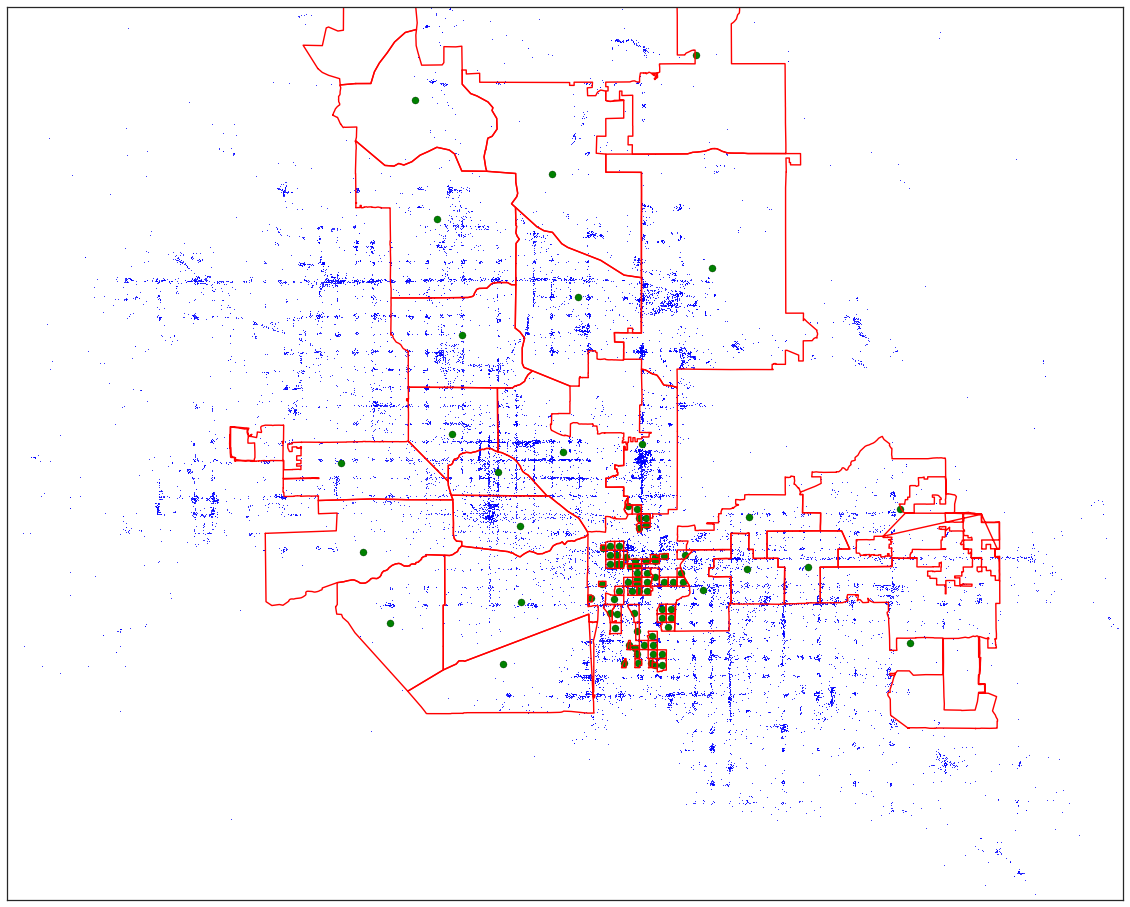

In [123]:
pylab.rcParams['figure.figsize'] = (20,16)

m = Basemap(width=100000,height=80000,projection='lcc',
            resolution='h',lat_1=34.0,lat_2=34.5,lat_0=33.5, lon_0=-112.0)
m.drawcoastlines()

for shape in sf.shapes():
    x,y = m(np.array(shape.points).T[0], np.array(shape.points).T[1])
    bx, by = m(np.array(b['longitude']), np.array(b['latitude']))
    cx, cy = m(np.array(nc[1]), np.array(nc[2]))
    m.plot(x,y, color = 'red')
    
m.scatter(bx,by, s = 1, lw = 0)
m.scatter(cx, cy, s = 50, c = 'green')

plt.savefig('phx_centers.png', dpi = 300, fmt = 'png')

In [124]:
from geopy.distance import great_circle # a distance finding function

In [57]:
nl = pd.read_csv('neighborhood_locations.csv') #read in our record of neighborhood locations

In [100]:
dists = []

yelp_business = (b['longitude'][400],b['latitude'][400])

for i in range(len(nl)):
    zillow_hood = (nl['lon'][i], nl['lat'][i])
    dists.append((great_circle(yelp_business, zillow_hood).miles, nl['ID'][i], i))

dists = sorted(dists) #sort by distance
dists = pd.DataFrame(dists).head() #provide the closest five hoods

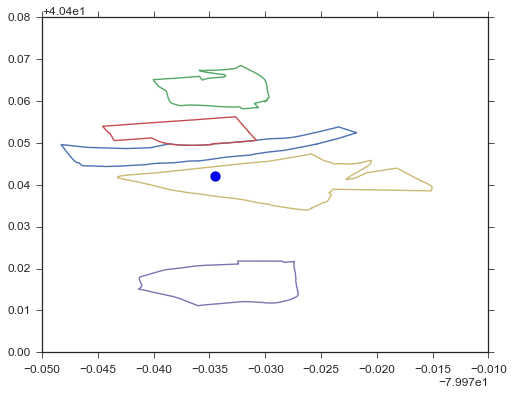

In [102]:
pylab.rcParams['figure.figsize'] = (8,6)

for hood in dists[2]:
    plt.plot(np.array(sf.shapes()[hood].points).T[0], np.array(sf.shapes()[hood].points).T[1])
plt.scatter(b['longitude'][400],b['latitude'][400], s = 100)

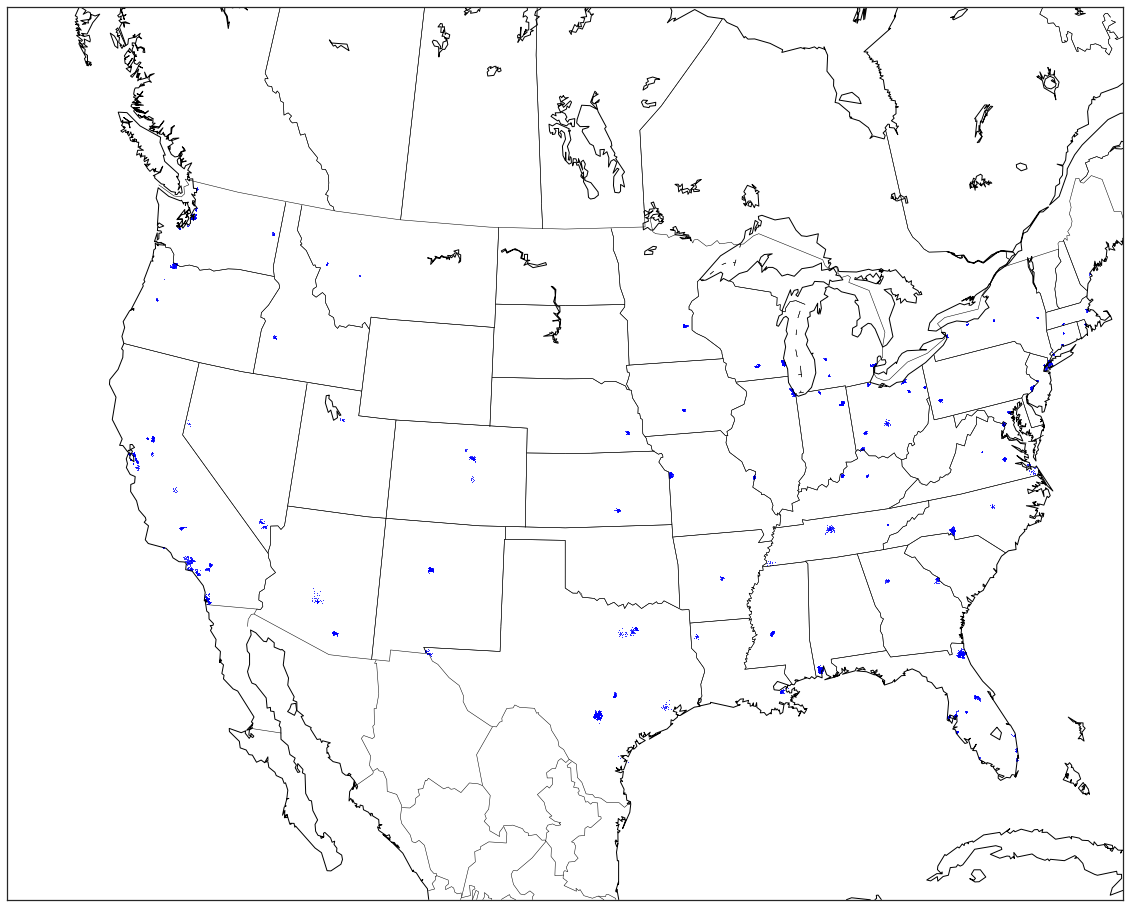

In [125]:
pylab.rcParams['figure.figsize'] = (20,16)

globe = Basemap(projection = 'lcc', resolution = 'l', lat_0 = 40, lon_0 = -100,\
               width=5000000,height=4000000)
zx, zy = globe(np.array(nl['lon']), np.array(nl['lat']))
#Fill the globe with a blue color 
globe.drawcountries()
globe.drawstates()
globe.drawcoastlines()
#Fill the continents with the land color
#globe.fillcontinents(color='coral',lake_color='aqua')
globe.scatter(zx,zy, s = 1, lw = 0)
plt.savefig('zillow_us_map.png', dpi = 300, fmt = 'png')